#   Tarea 2 pregunta 1


##  Importación bibliotecas

In [1]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.utils import save_img
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau



##  Extracción imágenes

In [2]:
def extraer_imagenes(directorio):
    """
    En esta parte solamente se importaran las imagenes, en la parte de mas abajo se normalizaran,
    con el fin de normalizar los datos ya estando en blanco y negro
    """
    imagenes_train=[]
    imagenes_test=[]

    for tipo_datos in ['train', 'test']:
        ruta_tipo = os.path.join(directorio, tipo_datos)
        for foto in os.listdir(ruta_tipo):
            ruta_foto=os.path.join(ruta_tipo,foto)
            try:
                img = image.load_img(ruta_foto,color_mode="rgb",target_size=(128,128))
                img_array = np.array(img)
                if tipo_datos == 'train':
                        imagenes_train.append(img_array)
                else:
                    imagenes_test.append(img_array)
            except Exception as e:
                print(f"Error al cargar {ruta_foto}: {e}")
    # Convertir a arrays y normalizar
    X_train = np.array(imagenes_train, dtype=np.float32)
    X_test = np.array(imagenes_test, dtype=np.float32)
    return X_train, X_test
    

In [3]:
X_train, X_test=extraer_imagenes("dataset_flores")

##  Convertidor de rgb a blanco y negro

In [4]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

##  Cambio imágenes de RGB a blanco y negro

In [5]:
X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)


##  Prueba de como se ven imagenes

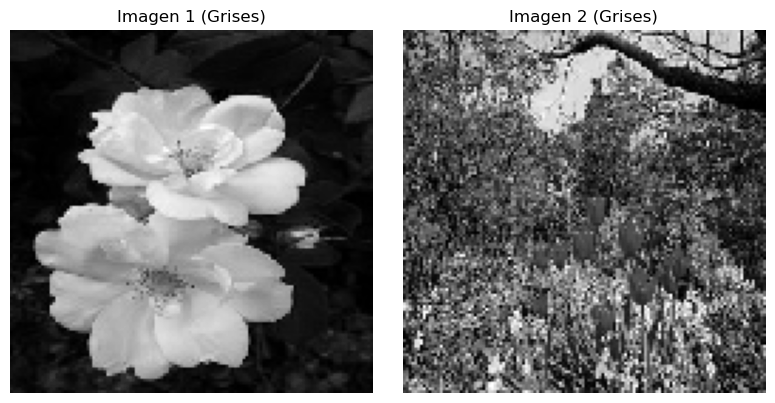

In [6]:
import matplotlib.pyplot as plt

# Mostramos dos imágenes de las que ya convertiste a escala de grises
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Primera imagen
axs[0].imshow(X_train_gray[0], cmap='gray')
axs[0].set_title('Imagen 1 (Grises)')
axs[0].axis('off')

# Segunda imagen
axs[1].imshow(X_train_gray[1], cmap='gray')
axs[1].set_title('Imagen 2 (Grises)')
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [7]:
def guardarImagenes(X_train_gray, X_test_gray):
    os.makedirs("imagenes_guardadas/train", exist_ok=True)
    os.makedirs("imagenes_guardadas/test", exist_ok=True)

    for i, img in enumerate(X_train_gray):
        # Asegura que tenga forma (alto, ancho, 1)
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        ruta = f"imagenes_guardadas/train/img_{i}.jpg"
        save_img(ruta, img, scale=True)

    for i, img in enumerate(X_test_gray):
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        ruta = f"imagenes_guardadas/test/img_{i}.jpg"
        save_img(ruta, img, scale=True)


In [8]:
guardarImagenes(X_train_gray,X_test_gray)

##  Normalización de datos

In [9]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
channels = X_train.shape[3]

In [10]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train_gray = X_train_gray.astype('float32') / 255 
X_test_gray = X_test_gray.astype('float32') / 255

x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)

X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], img_rows, img_cols, 1)
X_test_gray = X_test_gray.reshape(X_test_gray.shape[0], img_rows, img_cols, 1)

##  Modelo

In [11]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 512
layer_filters = [64, 128, 256]

In [12]:
# Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters,kernel_size=kernel_size,strides=2,activation='relu',padding='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 latent_vector (Dense)       (None, 512)               33554944  
                                                                 
Total params: 33,924,608
Trainable params: 33,924,608
Non-t

In [13]:
# Decoder
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=2,activation='relu',padding='same')(x)

outputs = Conv2DTranspose(filters=channels,kernel_size=kernel_size,
                          activation='sigmoid',padding='same',name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 65536)             33619968  
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 64)     7379

In [ ]:
def custom_loss(y_true, y_pred):
    # y_true: imagen a color original
    # y_pred: imagen a color generada

    # MSE entre color original y color generado
    mse_color = K.mean(K.square(y_true - y_pred))

    # Pasar a escala de grises (y_true es color, y_pred también)
    y_true_gray = rgb2gray(y_true)
    y_pred_gray = rgb2gray(y_pred)

    # MSE entre grises
    mse_gray = K.mean(K.square(y_true_gray - y_pred_gray))

    # Ponderaciones
    alpha = 0.7
    beta = 0.3

    return alpha * mse_color + beta * mse_gray

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=2,verbose=1,min_lr=0.5e-6)

checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_loss',verbose=1,save_best_only=True)

autoencoder.compile(loss=custom_loss    , optimizer='adam')
callbacks = [lr_reducer, checkpoint]

autoencoder.fit(X_train_gray,X_train,
                validation_data=(X_test_gray, X_test),
                epochs = 3,
                batch_size=batch_size,callbacks=callbacks)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 1)]     0         
                                                                 
 encoder (Functional)        (None, 512)               33924608  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       34580611  
                                                                 
Total params: 68,505,219
Trainable params: 68,505,219
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
42/42 [==============================] - ETA: 0s - loss: 0.0863
Epoch 1: val_loss improved from inf to 0.07767, saving model to c:\Users\newma\OneDrive\Escritorio\Universidad\Analisis de datos\REDES NEURONALES AVANZADAS DE APRENDIZAJE PROFUNDO\semana11\control2\Tarea_Grupal_2\saved_models\coloriz

In [ ]:
X_test_pred = autoencoder.predict(X_test_gray)
# Calculamos MSE para cada imagen
mse_test = np.mean((X_test - X_test_pred)**2, axis=(1, 2, 3))

# Índices de 3 peores y 3 mejores
idx_peores = np.argsort(mse_test)[-3:]
idx_mejores = np.argsort(mse_test)[:3]

# Guardamos imágenes de interés
os.makedirs('imagenes_identificadas', exist_ok=True)
for i, idx in enumerate(idx_peores):
    save_img(f'imagenes_identificadas/peor_{i}_gray.png', X_test_gray[idx])
    save_img(f'imagenes_identificadas/peor_{i}_original.png', X_test[idx])
    save_img(f'imagenes_identificadas/peor_{i}_generada.png', X_test_pred[idx])

for i, idx in enumerate(idx_mejores):
    save_img(f'imagenes_identificadas/mejor_{i}_gray.png', X_test_gray[idx])
    save_img(f'imagenes_identificadas/mejor_{i}_original.png', X_test[idx])
    save_img(f'imagenes_identificadas/mejor_{i}_generada.png', X_test_pred[idx])

print("Entrenamiento y guardado de resultados completados.")